In [1]:
# 필요한 라이브러리 불러오기
import os
import sys
import copy
from datetime import datetime
import gc
import pickle as pkl
import shelve

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
# GPU 가속 데이터 처리를 위한 라이브러리 -> pandas로 대체
# import cudf

sys.path.append("h&m_recommend_dataset/input/")

# H&M 추천 시스템 대회를 위한 커스텀 헬퍼 라이브러리
from handmhelpers import io as h_io, sub as h_sub, cv as h_cv, fe as h_fe
from handmhelpers import modeling as h_modeling, candidates as h_can, pairs as h_pairs
# h_io: 데이터 로딩, 저장 등의 입출력 작업
# h_sub: 예측 결과를 대회 제출 형식으로 변환
# h_cv: 교차 검증을 위한 데이터 분할 및 평가
# h_fe: 특성 엔지니어링 (날짜 변환, 고객/상품 특성 생성 등)
# h_modeling: 모델 학습 및 예측
# h_can: 추천 후보 아이템 생성
# h_pairs: 연관 상품 쌍 생성

## 데이터 불러오기

In [4]:
# EDA를 위해 데이터 불러오기
articles = pd.read_csv("h&m_recommend_dataset/articles.csv")
customers = pd.read_csv("h&m_recommend_dataset/customers.csv")
transactions = pd.read_csv("h&m_recommend_dataset/transactions_train.csv")

In [5]:
# 데이터 확인
print(articles.head(3))
print(customers.head(3))
print(transactions.head(3))

   article_id  product_code      prod_name  product_type_no product_type_name  \
0   108775015        108775      Strap top              253          Vest top   
1   108775044        108775      Strap top              253          Vest top   
2   108775051        108775  Strap top (1)              253          Vest top   

   product_group_name  graphical_appearance_no graphical_appearance_name  \
0  Garment Upper body                  1010016                     Solid   
1  Garment Upper body                  1010016                     Solid   
2  Garment Upper body                  1010017                    Stripe   

   colour_group_code colour_group_name  ...  department_name index_code  \
0                  9             Black  ...     Jersey Basic          A   
1                 10             White  ...     Jersey Basic          A   
2                 11         Off White  ...     Jersey Basic          A   

   index_name index_group_no  index_group_name section_no  \
0  Ladie

## EDA
* 각 데이터셋
    * 정보 확인
    * 시각화
    
필사 Notebook [H&M EDA FIRST LOOK](https://www.kaggle.com/code/vanguarde/h-m-eda-first-look/notebook)

### 상품 데이터셋 (articles.csv)

정보 확인

In [7]:
# 데이터 정보 확인
articles.info()
print("상품 데이터 갯수: ", articles.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

In [8]:
# 결측치 확인"
articles.isnull().sum()

article_id                        0
product_code                      0
prod_name                         0
product_type_no                   0
product_type_name                 0
product_group_name                0
graphical_appearance_no           0
graphical_appearance_name         0
colour_group_code                 0
colour_group_name                 0
perceived_colour_value_id         0
perceived_colour_value_name       0
perceived_colour_master_id        0
perceived_colour_master_name      0
department_no                     0
department_name                   0
index_code                        0
index_name                        0
index_group_no                    0
index_group_name                  0
section_no                        0
section_name                      0
garment_group_no                  0
garment_group_name                0
detail_desc                     416
dtype: int64

In [9]:
# 인덱스 그룹 이름과 인덱스 이름 카운트
articles.groupby(['index_group_name', 'index_name']).count()['article_id']

index_group_name  index_name                    
Baby/Children     Baby Sizes 50-98                   8875
                  Children Accessories, Swimwear     4615
                  Children Sizes 134-170             9214
                  Children Sizes 92-140             12007
Divided           Divided                           15149
Ladieswear        Ladies Accessories                 6961
                  Ladieswear                        26001
                  Lingeries/Tights                   6775
Menswear          Menswear                          12553
Sport             Sport                              3392
Name: article_id, dtype: int64

In [10]:
# 제품 그룹 이름과 제품 타입 이름 카운트
pd.options.display.max_rows = None
articles.groupby(['product_group_name', 'product_type_name']).count()['article_id']

product_group_name     product_type_name       
Accessories            Accessories set                 7
                       Alice band                      6
                       Baby Bib                        3
                       Bag                          1280
                       Beanie                         56
                       Belt                          458
                       Bracelet                      180
                       Braces                          3
                       Bucket hat                      7
                       Cap                            13
                       Cap/peaked                    573
                       Dog Wear                       20
                       Earring                      1159
                       Earrings                       11
                       Eyeglasses                      2
                       Felt hat                       10
                       Giftbox          

In [11]:
# 고유 값 카운트
for col in articles.columns:
    if not 'no' in col and not 'code' in col and not 'id' in col:
        un_n = articles[col].nunique()
        print(f'n of unique {col}: {un_n}')

n of unique prod_name: 45875
n of unique product_type_name: 131
n of unique product_group_name: 19
n of unique graphical_appearance_name: 30
n of unique colour_group_name: 50
n of unique perceived_colour_value_name: 8
n of unique perceived_colour_master_name: 20
n of unique department_name: 250
n of unique index_name: 10
n of unique index_group_name: 5
n of unique section_name: 56
n of unique garment_group_name: 21
n of unique detail_desc: 43404


시각화

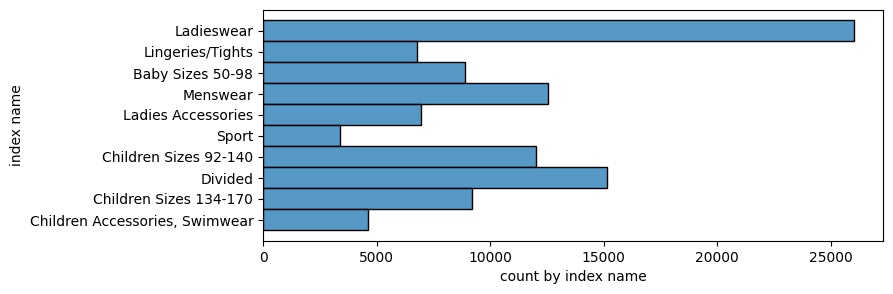

In [13]:
# index_name 시각화
f, ax = plt.subplots(figsize=(8, 3))
ax = sns.histplot(data=articles, y='index_name')
ax.set_xlabel('count by index name')
ax.set_ylabel('index name')
plt.show()

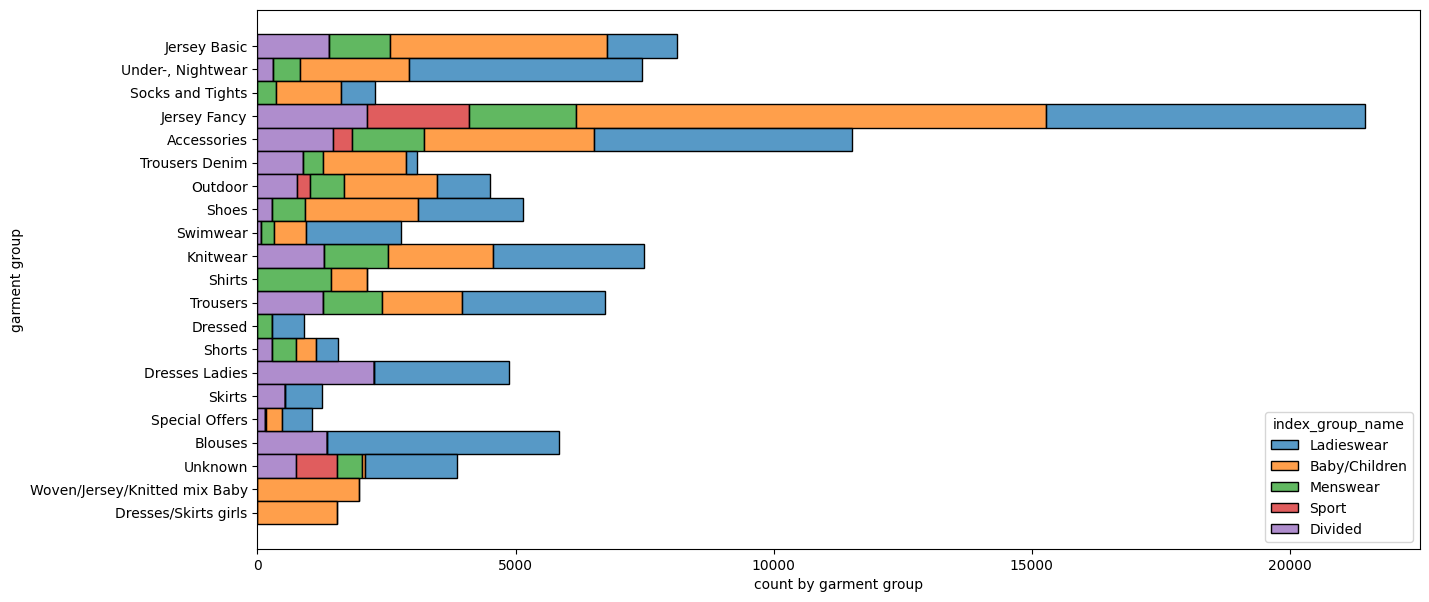

In [14]:
# garment 그룹 시각화
f, ax = plt.subplots(figsize=(15, 7))
ax = sns.histplot(data=articles, y='garment_group_name', color='orange', hue='index_group_name', multiple="stack")
ax.set_xlabel('count by garment group')
ax.set_ylabel('garment group')
plt.show()

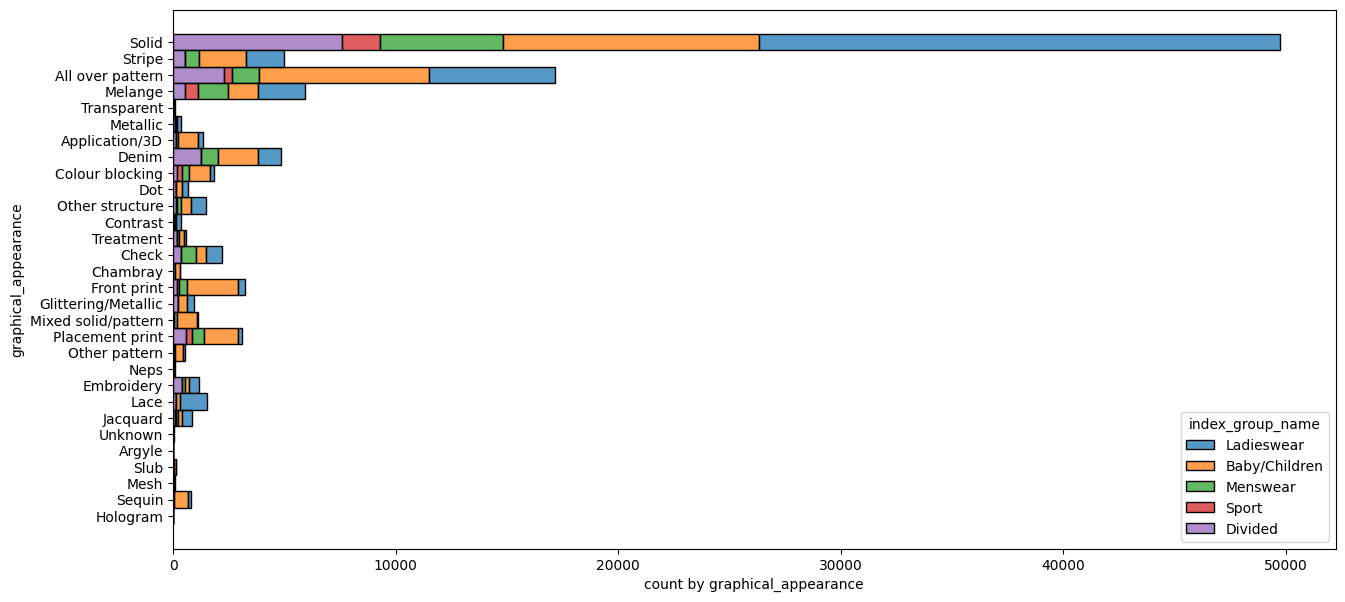

In [15]:
# graphical_appearance 시각화
f, ax = plt.subplots(figsize=(15, 7))
ax = sns.histplot(data=articles, y='graphical_appearance_name', color='orange', hue='index_group_name', multiple="stack")
ax.set_xlabel('count by graphical_appearance')
ax.set_ylabel('graphical_appearance')
plt.show()

### 고객 데이터셋 (customers.csv)

In [16]:
# 데이터 정보 확인
customers.info()
print("고객 데이터 갯수: ", customers.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1371980 non-null  object 
 1   FN                      476930 non-null   float64
 2   Active                  464404 non-null   float64
 3   club_member_status      1365918 non-null  object 
 4   fashion_news_frequency  1355969 non-null  object 
 5   age                     1356119 non-null  float64
 6   postal_code             1371980 non-null  object 
dtypes: float64(3), object(4)
memory usage: 73.3+ MB
고객 데이터 갯수:  (1371980, 7)


In [17]:
# 결측치 확인
customers.isnull().sum()

customer_id                    0
FN                        895050
Active                    907576
club_member_status          6062
fashion_news_frequency     16011
age                        15861
postal_code                    0
dtype: int64

In [18]:
# 고객 데이터 중복 확인
customers.shape[0] - customers['customer_id'].nunique()

0

In [19]:
# 우편번호 카운트 후 정렬
data_postal = customers.groupby('postal_code', as_index=False).count().sort_values('customer_id', ascending=False)
data_postal.head()

,postal_code,customer_id,FN,Active,club_member_status,fashion_news_frequency,age
61034,2c29ae653a9282cce4151bd87643c907644e09541abc28...,120303,42874,39886,118281,114377,118002
281937,cc4ed85e30f4977dae47662ddc468cd2eec11472de6fac...,261,109,104,261,261,260
156090,714976379549eb90aae4a71bca6c7402cc646ae7c40f6c...,159,90,88,159,159,158
171208,7c1fa3b0ec1d37ce2c3f34f63bd792f3b4494f324b6be5...,157,55,54,157,156,156
126228,5b7eb31eabebd3277de632b82267286d847fd5d44287ee...,156,42,41,156,156,155


In [20]:
# 우편번호 비정상적으로 많은 고객 확인
customers[customers['postal_code']=='2c29ae653a9282cce4151bd87643c907644e09541abc28ae87dea0d1f6603b1c'].head(3)

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
5,000064249685c11552da43ef22a5030f35a147f723d5b0...,NaN,NaN,NaN,NaN,NaN,2c29ae653a9282cce4151bd87643c907644e09541abc28...
8,00007e8d4e54114b5b2a9b51586325a8d0fa74ea23ef77...,NaN,NaN,ACTIVE,NONE,20.0,2c29ae653a9282cce4151bd87643c907644e09541abc28...
9,00008469a21b50b3d147c97135e25b4201a8c58997f787...,NaN,NaN,ACTIVE,NONE,20.0,2c29ae653a9282cce4151bd87643c907644e09541abc28...


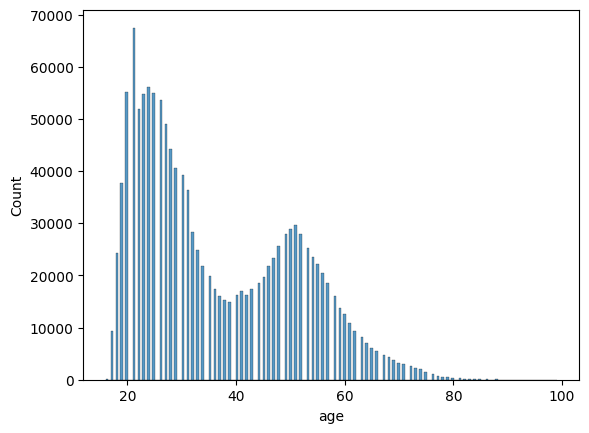

In [22]:
# 고객 나이 분포 시각화
sns.histplot(data=customers, x='age')
ax.set_xlabel('Distribution of the customers age')
plt.show()


Text(0.5, 24.140625000000007, 'Distribution of club member status')

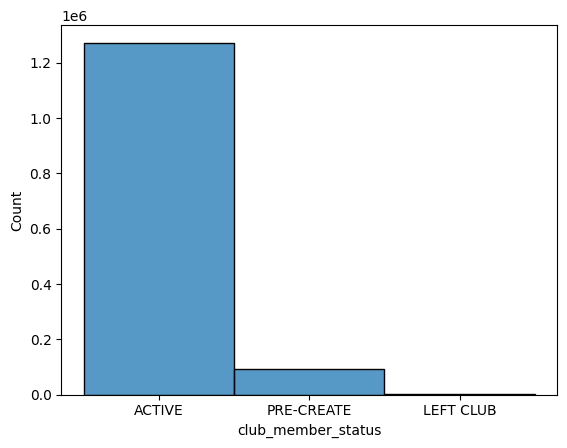

In [23]:
# H&M club 상태 시각화
sns.histplot(data=customers, x='club_member_status')
ax.set_xlabel('Distribution of club member status')

In [27]:
# 패션 뉴스 빈도 범주 확인
customers['fashion_news_frequency'].unique()

array(['NONE', 'Regularly', nan, 'Monthly'], dtype=object)

In [28]:
# Regularly, Monthly 이외의 범주는 None으로 변환
customers.loc[~customers['fashion_news_frequency'].isin(['Regularly', 'Monthly']), 'fashion_news_frequency'] = 'None'
customers['fashion_news_frequency'].unique()

array(['None', 'Regularly', 'Monthly'], dtype=object)

In [30]:
pie_data = customers[['customer_id', 'fashion_news_frequency']].groupby('fashion_news_frequency').count()

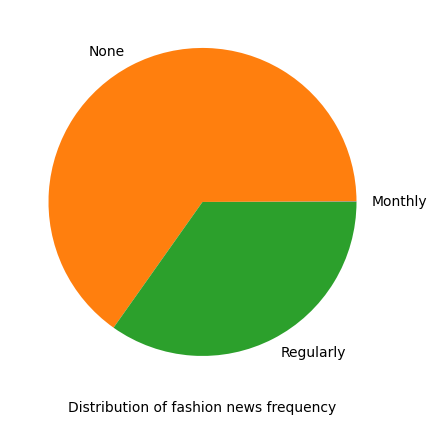

In [32]:
# 패션 뉴스 빈도 시각화
f, ax = plt.subplots(figsize=(10,5))
# ax = sns.histplot(data=customers, x='fashion_news_frequency', color='orange')
# ax = sns.pie(data=customers, x='fashion_news_frequency', color='orange')

ax.pie(pie_data.customer_id, labels=pie_data.index)
ax.set_facecolor('lightgrey')
ax.set_xlabel('Distribution of fashion news frequency')
plt.show()

### 거래 데이터셋 (transactions.csv)

In [33]:
transactions.info()
print("\n거래 데이터 갯수: ", transactions.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   t_dat             object 
 1   customer_id       object 
 2   article_id        int64  
 3   price             float64
 4   sales_channel_id  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.2+ GB

거래 데이터 갯수:  (31788324, 5)


In [34]:
transactions.isnull().sum()

t_dat               0
customer_id         0
article_id          0
price               0
sales_channel_id    0
dtype: int64

In [35]:
# price 컬럼 이상치 확인
pd.set_option('display.float_format', '{:.4f}'.format)
transactions.describe()['price']

count   31788324.0000
mean           0.0278
std            0.0192
min            0.0000
25%            0.0158
50%            0.0254
75%            0.0339
max            0.5915
Name: price, dtype: float64

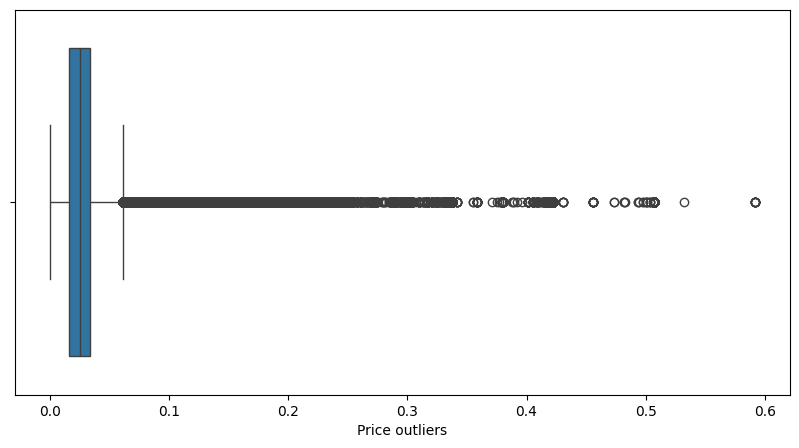

In [36]:
# price 이상치 시각화
f, ax = plt.subplots(figsize=(10,5))
ax = sns.boxplot(data=transactions, x='price')
ax.set_xlabel('Price outliers')
plt.show()

In [37]:
# 거래 건수 기준 상위 10명 고객 추출
transactions_byid = transactions.groupby('customer_id').count()
transactions_byid.sort_values(by='price', ascending=False)['price'][:10]

customer_id
be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee985513d9e8e53c6d91b    1895
b4db5e5259234574edfff958e170fe3a5e13b6f146752ca066abca3c156acc71    1441
49beaacac0c7801c2ce2d189efe525fe80b5d37e46ed05b50a4cd88e34d0748f    1364
a65f77281a528bf5c1e9f270141d601d116e1df33bf9df512f495ee06647a9cc    1361
cd04ec2726dd58a8c753e0d6423e57716fd9ebcf2f14ed6012e7e5bea016b4d6    1237
55d15396193dfd45836af3a6269a079efea339e875eff42cc0c228b002548a9d    1208
c140410d72a41ee5e2e3ba3d7f5a860f337f1b5e41c27cf9bda5517c8774f8fa    1170
8df45859ccd71ef1e48e2ee9d1c65d5728c31c46ae957d659fa4e5c3af6cc076    1169
03d0011487606c37c1b1ed147fc72f285a50c05f00b9712e0fc3da400c864296    1157
6cc121e5cc202d2bf344ffe795002bdbf87178054bcda2e57161f0ef810a4b55    1143
Name: price, dtype: int64

In [38]:
# 상품 데이터셋과 거래 데이터셋 병합
articles_for_merge = articles[['article_id', 'prod_name', 'product_type_name', 'product_group_name', 'index_name']]

articles_for_merge = transactions[['customer_id', 'article_id', 'price', 't_dat']].merge(articles_for_merge, on='article_id', how='left')

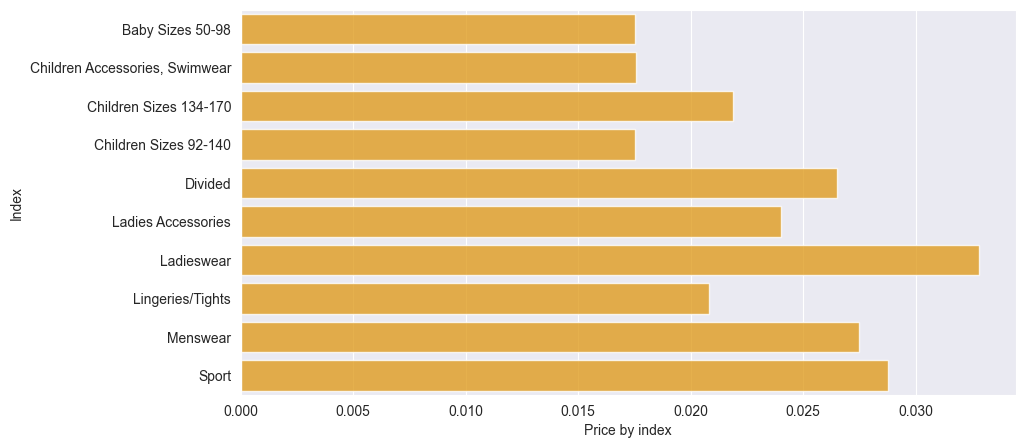

In [39]:
# 인덱스 이름 별 평균 가격 추출
articles_index = articles_for_merge[['index_name', 'price']].groupby('index_name').mean()

# 인덱스 이름 별 평균 가격 시각화
f, ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(x=articles_index.price, y=articles_index.index, color='orange', alpha=0.8)
ax.set_xlabel('Price by index')
ax.set_ylabel('Index')
plt.show()

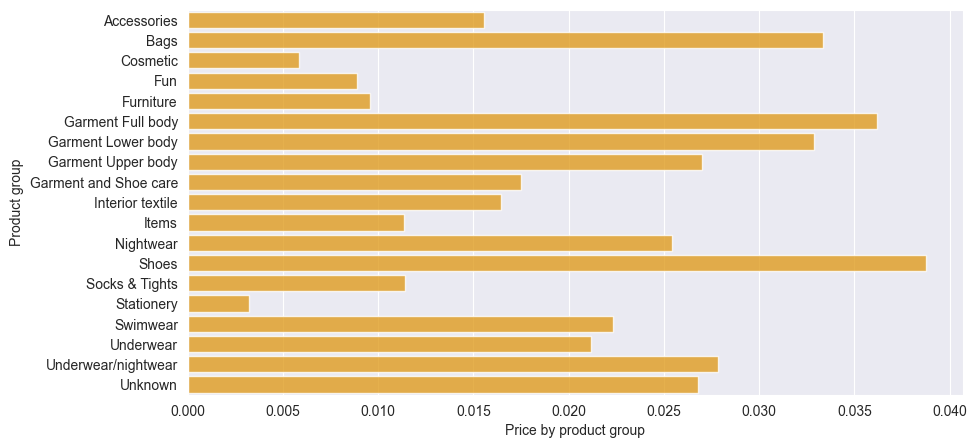

In [40]:
# 제품 그룹 이름 별 평균 가격 추출
articles_index = articles_for_merge[['product_group_name', 'price']].groupby('product_group_name').mean()

# 제품 그룹 이름 별 평균 가격 시각화
f, ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(x=articles_index.price, y=articles_index.index, color='orange', alpha=0.8)
ax.set_xlabel('Price by product group')
ax.set_ylabel('Product group')
plt.show()